### SARSA (State-Action-Reward-State-Action) Algorithm Implementation

SARSA is an ON-POLICY Temporal Difference (TD) learning algorithm.

Key Characteristics:
- On-policy: Learns the value of the policy being followed (including exploration)
- TD Learning: Updates estimates based on other estimates (bootstrapping)
- Model-free: Doesn't require knowledge of environment dynamics

Update Rule:
    Q(s,a) ← Q(s,a) + α[r + γQ(s',a') - Q(s,a)]

Where:
    s: current state
    a: action taken from s
    r: reward received
    s': next state
    a': next action (chosen by same policy - KEY DIFFERENCE from Q-learning)
    α: learning rate (how much to update)
    γ: discount factor (importance of future rewards)

Underlying MDP Framework:
- States (S): Grid positions (driver_x, driver_y, dest_x, dest_y)
- Actions (A): {0: Right, 1: Up, 2: Left, 3: Down}
- Transition Function P(s'|s,a): Deterministic grid movement with obstacle collision
- Reward Function R(s,a,s'): Distance-based penalties + goal reward + obstacle penalty
- Policy π(a|s): ε-greedy (exploration vs exploitation trade-off)

In [38]:
import numpy as np
import gymnasium as gym
import time
from Map import MapEnv
from collections import defaultdict
from tqdm import tqdm
from matplotlib import pyplot as plt
from typing import List, Optional

# SARSA LOGIC
- Initialize q-table, learning rate, discount and epsilon
- Convert environment obs into tuple for Q-table
- Implement epsilon greedy (exploration vs exploitation)
- SARSA update
- Gradual shift of epsilon from exploration to exploitation

In [39]:
class SARSAAgent:
    def __init__(
        self,
        env: gym.Env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float,
    ):
        self.env = env
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))
        self.lr = learning_rate
        self.discount_factor = discount_factor
        self.initial_epsilon = initial_epsilon
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.training_error = []
        self.episode_count = 0

    def _obs_to_tuple(self, obs):
        d = obs["driver"]
        dest = obs["destination"]
        return (int(d[0]), int(d[1]), int(dest[0]), int(dest[1]))

    def choose_action(self, obs: tuple[int, int, bool]) -> int:
        obs_tuple = self._obs_to_tuple(obs)
        # Exploration
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
        # Exploitation
            return int(np.argmax(self.q_values[obs_tuple]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
        next_action: int, 
    ):
        obs_tuple = self._obs_to_tuple(obs)
        next_obs_tuple = self._obs_to_tuple(next_obs)

        # SARSA: Use actual next action (not max)
        future_q_value = (not terminated) * self.q_values[next_obs_tuple][next_action]
        destination = reward + self.discount_factor * future_q_value
        temporal_difference = destination - self.q_values[obs_tuple][action]

        self.q_values[obs_tuple][action] = (
            self.q_values[obs_tuple][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        """Linear decay from initial_epsilon to final_epsilon"""
        self.episode_count += 1
        # Linear interpolation
        self.epsilon = max(
            self.final_epsilon,
            self.initial_epsilon - (self.epsilon_decay * self.episode_count)
        )

# Training and Visualization

In [40]:
def train_agent(agent, env, n_episodes: int, log_interval: int=5000):
    episode_rewards = []
    episode_lengths = []
    epsilon_history = []
    success_rate_history = []

    print(f"\nTraining for {n_episodes} episodes...\n")

    for episode in tqdm(range(n_episodes), desc="Training"):
        obs, info = env.reset()
        done = False
        episode_reward = 0
        steps = 0

        #choose initial action
        action = agent.choose_action(obs)

        while not done:
            next_obs, reward, terminated, truncated, info = env.step(action)

            # choose next action before update
            next_action = agent.choose_action(next_obs)

            #update using actual next action
            agent.update(obs, action, reward, terminated, next_obs, next_action)

            episode_reward += reward
            steps += 1
            done = terminated or truncated
            obs = next_obs
            action = next_action

        agent.decay_epsilon()
        episode_rewards.append(episode_reward)
        episode_lengths.append(steps)
        epsilon_history.append(agent.epsilon)

        if episode >= 99:
            recent_successes = [1 if r > 0 else 0 for r in episode_rewards[-100:]]
            success_rate_history.append(np.mean(recent_successes))

        if (episode + 1) % log_interval == 0:
            recent_rewards = episode_rewards[-1000:]
            tqdm.write(f"\nEpisode {episode + 1}/{n_episodes}")
            tqdm.write(f"  Avg Reward: {np.mean(recent_rewards):.2f}")
            tqdm.write(f"  Success Rate: {np.mean(recent_successes):.1%}")
            tqdm.write(f"  Avg Steps: {np.mean(episode_lengths[-1000:]):.1f}")
            tqdm.write(f"  Epsilon: {agent.epsilon:.4f}")
            tqdm.write(f"  States: {len(agent.q_values)}")

        # success rate over all episodes
    overall_success_rate = np.mean([1 if r > 0 else 0 for r in episode_rewards])

    print(f"\nTraining complete. States explored: {len(agent.q_values)}")
    print(f"Final epsilon: {agent.epsilon:.4f}")
    print(f"Overall Success Rate: {overall_success_rate:.1%}")


    return {
        "episode_rewards": episode_rewards,
        "episode_lengths": episode_lengths,
        "epsilon_history": epsilon_history,
        "success_rate_history": success_rate_history,
        "overall_success_rate": overall_success_rate,
    }


In [41]:
def visualize_training(results, agent, n_episodes, window=100, algo_name='SARSA', save_path=None):
    import numpy as np
    import matplotlib.pyplot as plt
    episode_rewards = results["episode_rewards"]
    episode_lengths = results["episode_lengths"]
    success_rate_history = results["success_rate_history"]
    epsilon_history = results.get("epsilon_history", [])
    total_time = results.get("total_time", None)
    avg_time = results.get("avg_time_per_episode", None)
    td_errors = getattr(agent, "training_error", [])
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'{algo_name} Training Metrics', fontsize=16, fontweight='bold')
    def get_moving_avgs(data, window=100, mode='valid'):
        return np.convolve(data, np.ones(window) / window, mode=mode)
    # 1. Episode Rewards
    ax = axes[0, 0]
    rewards_ma = get_moving_avgs(episode_rewards, window, 'valid')
    ax.plot(episode_rewards, alpha=0.2, color='blue', label='Raw')
    ax.plot(range(window-1, len(episode_rewards)), rewards_ma,
            color='blue', linewidth=2, label=f'{window}-ep MA')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Total Reward')
    ax.set_title('Episode Rewards')
    ax.legend()
    ax.grid(True, alpha=0.3)
    # 2. Success Rate
    ax = axes[0, 1]
    ax.plot(range(window-1, window-1 + len(success_rate_history)),
            np.array(success_rate_history) * 100,
            color='orange', linewidth=2.5, label=f'Rolling Success Rate ({window}ep)')
    ax.axhline(y=100, color='gray', linestyle='--', alpha=0.5, linewidth=1, label='Perfect (100%)')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Success Rate (%)')
    ax.set_title('Success Rate Over Time')
    ax.set_ylim(0, 105)
    ax.legend()
    ax.grid(True, alpha=0.3)
    if len(success_rate_history) > 0:
        final_success = success_rate_history[-1] * 100
        ax.text(0.98, 0.02, f'Final: {final_success:.1f}%',
                transform=ax.transAxes, ha='right', va='bottom',
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    # 3. Steps per Episode
    ax = axes[0, 2]
    lengths_ma = get_moving_avgs(episode_lengths, window, 'valid')
    ax.plot(episode_lengths, alpha=0.2, color='green', label='Raw')
    ax.plot(range(window-1, len(episode_lengths)), lengths_ma,
            color='green', linewidth=2, label=f'{window}-ep MA')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Steps')
    ax.set_title('Steps per Episode')
    ax.legend()
    ax.grid(True, alpha=0.3)
    # 4. TD Errors
    ax = axes[1, 0]
    if len(td_errors) > 0:
        if len(td_errors) > window:
            td_ma = np.convolve(td_errors, np.ones(window)/window, mode='valid')
            ax.plot(td_errors, alpha=0.2, color='red', label='Raw')
            ax.plot(range(window-1, len(td_errors)), td_ma,
                    color='red', linewidth=2, label=f'{window}-ep MA')
        else:
            ax.plot(td_errors, color='red')
        ax.set_xlabel('Episode')
        ax.set_ylabel('Mean |TD Error|')
        ax.set_title('Learning Stability (TD Errors)')
        ax.legend()
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, "No TD error data", ha='center', va='center', fontsize=10, color='gray')
        ax.axis('off')
    # 5. Epsilon Decay
    ax = axes[1, 1]
    if len(epsilon_history) > 0:
        ax.plot(epsilon_history, color='orange', linewidth=2)
        ax.set_xlabel('Episode')
        ax.set_ylabel('Epsilon (ε)')
        ax.set_title('Exploration Rate Decay')
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-0.05, 1.05)
    else:
        ax.text(0.5, 0.5, "No epsilon history", ha='center', va='center',
                fontsize=10, color='gray')
        ax.axis('off')
    # 6. Cumulative Reward
    ax = axes[1, 2]
    cumulative_rewards = np.cumsum(episode_rewards)
    ax.plot(cumulative_rewards, color='purple', linewidth=2)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Cumulative Reward')
    ax.set_title('Cumulative Reward Over Episodes')
    ax.grid(True, alpha=0.3)
    
    # 7. Training Efficiency - Add BEFORE tight_layout
    n_episodes = len(results["episode_rewards"])
    
    if total_time is not None:
        avg_time = total_time / n_episodes
        efficiency_text = (
            f"Training Efficiency  |  "
            f"Total Time: {total_time:.2f}s  |  "
            f"Episodes: {n_episodes}  |  "
            f"Avg/Episode: {avg_time:.4f}s"
        )
        fig.text(
            0.5, 0.015, efficiency_text,
            ha='center', va='bottom', fontsize=10,
            bbox=dict(boxstyle='round', facecolor='lavender', alpha=0.5, pad=0.6)
        )
    else:
        fig.text(
            0.5, 0.015, "Training Efficiency: Timing data not available",
            ha='center', va='bottom', fontsize=10, color='gray',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.3, pad=0.6)
        )
    
    # Call tight_layout AFTER adding the text, with proper spacing
    plt.tight_layout(rect=[0, 0.04, 1, 0.97])
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
    else:
        filename = f'{algo_name.lower()}_training_metrics.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Saved: {filename}")
    plt.show()

# Testing and Visualization

In [42]:
def test_agent(agent, env, n_episodes: int = 100, success_threshold: float = 0):

    total_rewards = []
    successes = []
    episode_lengths = []

    old_epsilon = agent.epsilon
    agent.epsilon = 0.0  # no exploration

    for _ in tqdm(range(n_episodes), desc="Testing"):
        obs, info = env.reset()
        episode_reward = 0
        steps = 0
        done = False

        while not done:
            action = agent.choose_action(obs)
            obs, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward
            steps += 1
            done = terminated or truncated

        total_rewards.append(episode_reward)
        successes.append(1 if episode_reward > success_threshold else 0)
        episode_lengths.append(steps)

    # restore epsilon
    agent.epsilon = old_epsilon

    results = {
        "success_rate": np.mean(successes),
        "avg_reward": np.mean(total_rewards),
        "std_reward": np.std(total_rewards),
        "avg_length": np.mean(episode_lengths),
        "std_length": np.std(episode_lengths),
        "rewards": total_rewards,
        "lengths": episode_lengths,
    }

    # Optional summary print
    print(f"\n{'='*60}")
    print(f"TEST RESULTS ({n_episodes} episodes)")
    print(f"{'='*60}")
    print(f"Success Rate: {results['success_rate']:.1%}")
    print(f"Average Reward: {results['avg_reward']:.3f} ± {results['std_reward']:.3f}")
    print(f"Average Episode Len: {results['avg_length']:.1f} ± {results['std_length']:.1f}")
    print(f"{'='*60}")

    return results


In [43]:
def visualize_testing_progress(agent, env_class, n_episodes=10):
    render_env = env_class(render_mode="human")
    old_epsilon = agent.epsilon
    agent.epsilon = 0.0  # pure exploitation mode

    for episode in range(n_episodes):
        obs, info = render_env.reset()
        episode_reward = 0
        steps = 0
        done = False

        print(f"\n=== Episode {episode + 1} ===")
        print(f"Driver at: {obs['driver']}, Destination at: {obs['destination']}")

        while not done:
            action = agent.choose_action(obs)
            obs, reward, terminated, truncated, info = render_env.step(action)
            episode_reward += reward
            steps += 1
            done = terminated or truncated

        print(f"Episode finished in {steps} steps")
        print(f"Total reward: {episode_reward:.2f}")
        print(f"Success: {'Yes' if terminated else 'No'}")

    agent.epsilon = old_epsilon
    render_env.close()


In [44]:
n_episodes = 20000
env = MapEnv(render_mode=None)

initial_eps = 1.0
final_eps = 0.008
epsilon_decay = (initial_eps - final_eps) / n_episodes

agent = SARSAAgent(
    env=env,
    learning_rate=0.16,
    initial_epsilon=initial_eps,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_eps,
    discount_factor=0.95,
)

print(f"Environment: {env.size}×{env.size} grid, {len(env._obstacles)} obstacles")
print(f"Hyperparameters: ")
print(f"  Learning Rate: {agent.lr}")
print(f"  Discount Factor: {agent.discount_factor}")
print(f"  Epsilon: start={agent.epsilon}, end={agent.final_epsilon}, decay={agent.epsilon_decay}")

Environment: 8×8 grid, 8 obstacles
Hyperparameters: 
  Learning Rate: 0.16
  Discount Factor: 0.95
  Epsilon: start=1.0, end=0.008, decay=4.96e-05


In [45]:
print("\nTraining...\n")

start_time = time.time()
train_results = train_agent(agent, env, n_episodes)
train_results["total_time"] = time.time() - start_time
train_results["avg_time_per_episode"] = train_results["total_time"] / n_episodes



Training...


Training for 20000 episodes...



Training:  25%|██▌       | 5051/20000 [00:30<01:14, 201.24it/s]


Episode 5000/20000
  Avg Reward: 45.28
  Success Rate: 66.0%
  Avg Steps: 52.1
  Epsilon: 0.7520
  States: 3136


Training:  50%|█████     | 10036/20000 [00:52<00:44, 225.49it/s]


Episode 10000/20000
  Avg Reward: 65.98
  Success Rate: 74.0%
  Avg Steps: 37.7
  Epsilon: 0.5040
  States: 3136


Training:  75%|███████▌  | 15023/20000 [01:09<00:14, 347.88it/s]


Episode 15000/20000
  Avg Reward: 72.63
  Success Rate: 78.0%
  Avg Steps: 30.9
  Epsilon: 0.2560
  States: 3136


Training: 100%|██████████| 20000/20000 [01:22<00:00, 242.36it/s]


Episode 20000/20000
  Avg Reward: 75.17
  Success Rate: 68.0%
  Avg Steps: 27.8
  Epsilon: 0.0080
  States: 3136

Training complete. States explored: 3136
Final epsilon: 0.0080
Overall Success Rate: 70.2%


Plot saved to sarsa_training_metrics.png


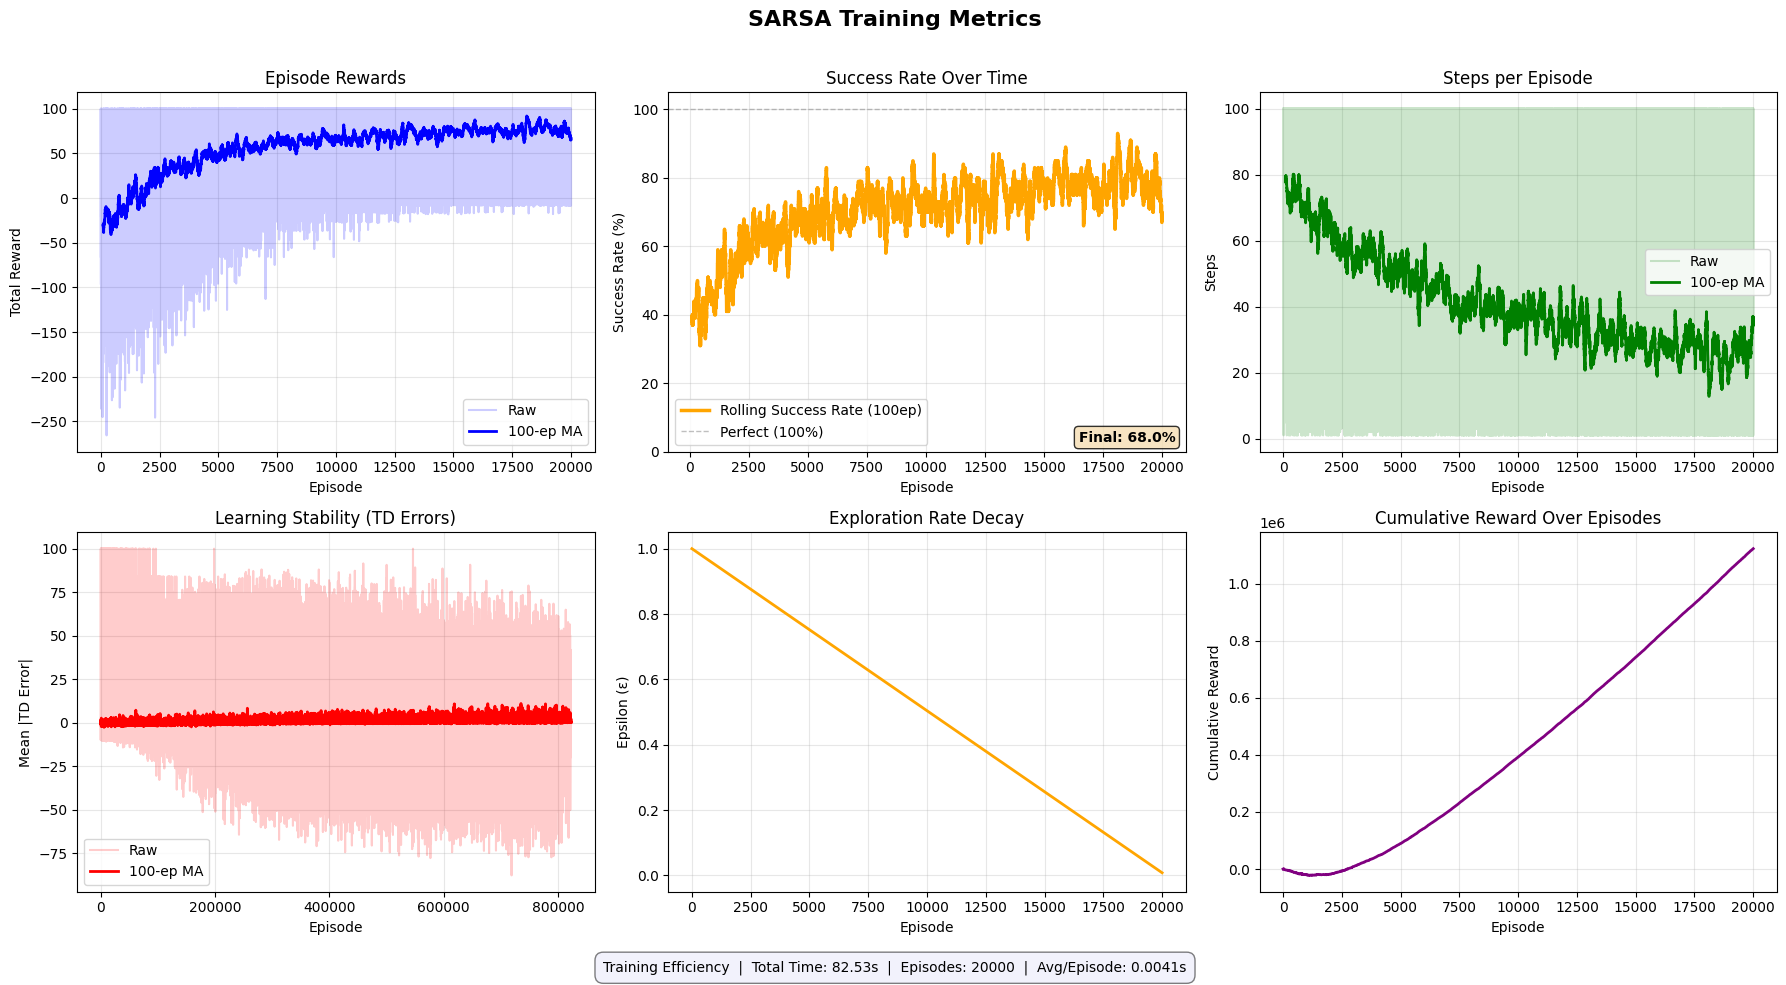

In [46]:
visualize_training(train_results, agent, n_episodes, window=100, algo_name='SARSA', save_path='sarsa_training_metrics.png')

In [47]:
print("\nTesting... \n")
test_results = test_agent(agent, env, 10)

visualize_testing_progress(agent, MapEnv, n_episodes=10)


Testing... 



Testing: 100%|██████████| 10/10 [00:00<00:00, 50.25it/s]



TEST RESULTS (10 episodes)
Success Rate: 60.0%
Average Reward: 57.645 ± 51.775
Average Episode Len: 42.8 ± 46.7

=== Episode 1 ===
Driver at: [2 1], Destination at: [5 1]
Episode finished in 3 steps
Total reward: 99.97
Success: Yes

=== Episode 2 ===
Driver at: [7 0], Destination at: [0 4]
Episode finished in 11 steps
Total reward: 99.60
Success: Yes

=== Episode 3 ===
Driver at: [5 0], Destination at: [3 1]
Episode finished in 3 steps
Total reward: 99.98
Success: Yes

=== Episode 4 ===
Driver at: [4 0], Destination at: [4 1]
Episode finished in 1 steps
Total reward: 100.00
Success: Yes

=== Episode 5 ===
Driver at: [4 5], Destination at: [2 1]
Episode finished in 100 steps
Total reward: -6.71
Success: No

=== Episode 6 ===
Driver at: [3 1], Destination at: [5 5]
Episode finished in 10 steps
Total reward: 99.67
Success: Yes

=== Episode 7 ===
Driver at: [1 5], Destination at: [3 5]
Episode finished in 2 steps
Total reward: 99.99
Success: Yes

=== Episode 8 ===
Driver at: [4 6], Destin

In [48]:
# Summary

print("\n" + "="*70)
print("SARSA SUMMARY")
print("="*70)
print(f"Training Episodes:  {n_episodes:}")
print(f"States Explored:    {len(agent.q_values):}")
print(f"Total Updates:      {len(agent.training_error):}")
print(f"Final Epsilon:      {agent.epsilon:.5f}")
print("="*70)

env.close()


SARSA SUMMARY
Training Episodes:  20000
States Explored:    3136
Total Updates:      822694
Final Epsilon:      0.00800
